# 1. 라이브러리 import

In [ ]:
import torch
import transformers
from transformers import AutoModelWithLMHead, PreTrainedTokenizerFast
from fastai.text.all import *
import re
import fastai

print(torch.__version__)
print(transformers.__version__)
print( fastai.__version__)

C:\Users\User\anaconda3\envs\GPU1\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.8.0
4.20.1
2.7.7


# 2. Fine-tuning 전 kogpt2

In [4]:
tokenizer = PreTrainedTokenizerFast.from_pretrained("skt/kogpt2-base-v2",
  bos_token='</s>', eos_token='</s>', unk_token='<unk>',
  pad_token='<pad>', mask_token='<mask>') 
model = AutoModelWithLMHead.from_pretrained("skt/kogpt2-base-v2")
text = """ 매일 같은 옷을 입는 이유 너와 함께 입던 옷이라서 """
input_ids = tokenizer.encode(text)
gen_ids = model.generate(torch.tensor([input_ids]),
                           max_length=128,
                           repetition_penalty=2.0,
                           pad_token_id=tokenizer.pad_token_id,
                           eos_token_id=tokenizer.eos_token_id,
                           bos_token_id=tokenizer.bos_token_id,
                           use_cache=True
                        )
generated = tokenizer.decode(gen_ids[0,:].tolist())
print(generated)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.
C:\Users\User\anaconda3\envs\GPU1\lib\site-packages\transformers\models\auto\modeling_auto.py:969: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


매일 같은 옷을 입는 이유 너와 함께 입던 옷이라서 괜찮아.
그런데 왜 이렇게 입고 다니냐고?
너랑 같이 입어라!
이거 뭐야? 이게 무슨 짓이야! 내가 니가 좋아하는 거잖아, 나 지금 어디 있어.</d> 오늘은 어떤 분을 소개해 드릴까요?
오늘의 주제는 바로 '우리 시대의 가장 큰 문제'입니다.
저도 그 문제에 대해서 좀 더 깊이 있게 고민하고 싶습니다.
먼저, 김지영 기자 나와 있습니다.
어서 오십시오, 안녕하세요.
네. 저는 이제 막 고등학교를 졸업하고 대학 진학을 준비하던 중이었어요.
그래서, 제가 대학교에


# 3. 데이터 전처리

In [5]:
import os
import re

with open('./data/kr_lyrics_20.txt', 'r', encoding='utf-8') as f:
    data = f.read()
data=" ".join(data.split())
# print(len(data))
data = data.replace('\n|\t', ' ')
print(len(data))
# new_sent = data.replace(" ", '') # 띄어쓰기가 없는 문장 임의로 만들기
# # print(len(new_sent))
# spacing = Spacing()
# kospacing_sent = spacing(new_sent) 
# print(len(kospacing_sent))
data = re.sub('[-=+,#/\:^$@*\"※~&%ㆍ』\\‘|\(\)\[\]\<\>`\'…》]','', data)
print(len(data))
data = re.sub('[a-zA-Z]' , '', data)
print(len(data))
data = re.sub(r'[0-9]+' , '', data)
print(len(data))
# UnicodeDecodeError: 'cp949' codec can't decode byte 0xec in position 20: illegal multibyte sequence
# 해당 에러 ->  encoding='utf-8' 넣어 주기

18196
18060
11640
11591


In [7]:
# Open a text file in write mode
with open('./data/kr_lyrics_20_preprocess.txt', 'w', encoding='utf-8') as file:
    # Write the string to the file
    file.write(data)

# 4. 데이터 로드 & Tokenize

In [8]:
with open('./data/kr_lyrics_20_preprocess.txt', 'r', encoding='utf-8') as f:
    data = f.read()

#model input output tokenizer
class TransformersTokenizer(Transform):
   def __init__(self, tokenizer): self.tokenizer = tokenizer
   def encodes(self, x): 
       toks = self.tokenizer.tokenize(x)
       return tensor(self.tokenizer.convert_tokens_to_ids(toks))
   def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

#split data
train=data[:int(len(data)*0.9)]
test=data[int(len(data)*0.9):]
splits = [[0],[1]]

#init dataloader
tls = TfmdLists([train,test], TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)
dls = tls.dataloaders(bs=4, seq_len=128)

# 5. 모델 훈련

SuggestedLRs(valley=5.248074739938602e-05)


epoch,train_loss,valid_loss,perplexity,time
0,3.859064,3.869008,47.894833,00:02
1,3.666029,3.755683,42.763424,00:02
2,3.503466,3.680389,39.661835,00:02
3,3.319093,3.661211,38.908424,00:02
4,3.095073,3.776760,43.674313,00:02
5,2.836806,3.829710,46.049160,00:02
6,2.546045,3.877259,48.291679,00:02
7,2.255402,4.020679,55.738914,00:02
8,1.981694,4.424123,83.439583,00:02
9,1.736849,4.199149,66.629585,00:02


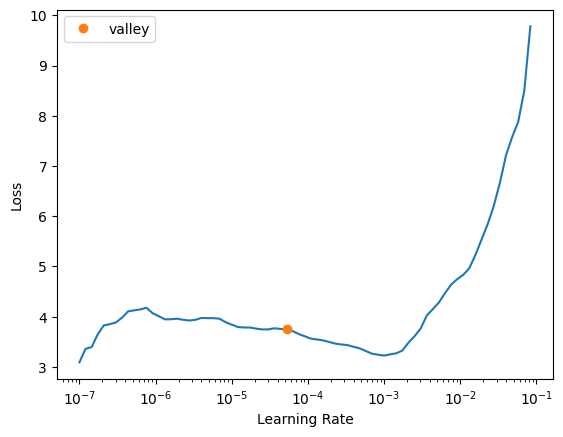

In [9]:
#gpt2 ouput is tuple, we need just one val
class DropOutput(Callback):
  def after_pred(self): self.learn.pred = self.pred[0]
      
      
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), 
cbs=[DropOutput], metrics=Perplexity()).to_fp16()

lr=learn.lr_find()
print(lr)
learn.fit_one_cycle(50, lr)

# 6. Fine-tuning 결과

In [10]:
prompt=" 매일 같은 옷을 입는 이유 너와 함께 입던 옷이라서 "
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
preds = learn.model.generate(inp,
                           max_length=128,
                           pad_token_id=tokenizer.pad_token_id,
                           eos_token_id=tokenizer.eos_token_id,
                           bos_token_id=tokenizer.bos_token_id,
                           repetition_penalty=2.0,       
                           use_cache=True
                          ) 
tokenizer.decode(preds[0].cpu().numpy())

'매일 같은 옷을 입는 이유 너와 함께 입던 옷이라서 괜히 어색할까 혼자 애만 태우다 끝끝내 망설여왔던 순간 알잖아 나 무뚝하고 말도 없는 걸 서툰 표현이 쑥스러워서 쓰다가 지울 문자도 없이 떠나 이대로는 무엇 하러 아등바등,해줘 그때 그 여름을 틀어줬지 꼴리는 대로 해봤자 별 것 아닌 일에도 점점 내 습관이 돼버린 널 보면서 심장이 뛰고 싶다고 막 짜증낼 힘조차 없어 여유마저 없고 뭐 그리 아니꼬와, 가던 길 그냥 가 왜들 그래 이리 혼란스러워 이러'

# 7. 모델 저장

In [11]:
learn.model.save_pretrained("./models/kogpt2_backup_50")